## Classificação de imagens
a idéia proposta para essa CNN(Convolutional neural network ou rede neural convolucional) é fazer o uso de transfer learning, onde é possível utilizar estruturas(redes neurais) ja existentes adaptando-as para o problema proposto, conseguindo assim, vários benefícios
como pesos(weights) que ja foram treinados, sendo assim necessário treinar apenas os pesos da última camada da rede neural, aumentando assim a velocidade de treinamento do modelo e a acúracia do mesmo por se tratar de uma rede já treinada com milhares de imagens.
Neste caso estou utilizando Resnet para classificar ambientes.
A rede será treinada para classificar imagens de 3 tipos:
- imagens de prédios
- imagens de florestas
- imagens de montanhas

In [234]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [235]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [236]:
from glob import glob

## Definindo as varíaveis necessárias para criação do modelo.

In [254]:
train_path = 'seg_train' # pasta com imagens para treinamento do modelo.
validation_path = 'seg_valid' # pasta com imagens para validação.
test_path = 'seg_pred' # pasta com imagens para predição.
IMAGE_SIZE = [224,224] # altura e comprimento das imagens.
epochs = 2
batch_size = 30

## Checando o formato da imagem.

In [255]:
if K.image_data_format() == 'channels_first':
    input_shape = ([3] + IMAGE_SIZE)
else:
    input_shape = (IMAGE_SIZE + [3])

## Localização dos diretórios necessários.

In [256]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(validation_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')

In [257]:
folders = glob(train_path + '/*')

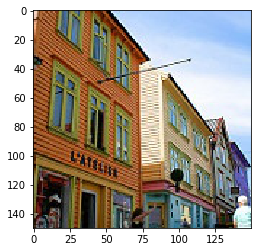

In [258]:
plt.imshow(image.load_img(np.random.choice(image_files)))

## Importando o modelo(ResNet).

In [259]:
res = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

In [260]:
# Retirando a necessidade de treinamento dos pesos pré treinados pelo modelo(Resnet).
for layer in res.layers:
    layer.trainable = False

In [261]:
x = Flatten()(res.output) # Adicionando a camada Flatten ao final do modelo.

In [262]:
prediction = Dense(len(folders), activation='softmax')(x) # Adicionando a camada final(output).

In [263]:
model = Model(inputs=res.input, outputs=prediction) # Criando um novo modelo com as especificações definidas acima.

In [264]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [265]:
# Compilando o modelo.
model.compile(
              loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

In [266]:
# Utilizando ImageDataGenerator para aplicar alguns features nas imagens.
gen = ImageDataGenerator(rotation_range=20,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.1,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         preprocessing_function=preprocess_input)

In [267]:
# Adaptando as imagens de treino para o formato adequado ao modelo.
train_datagen = gen.flow_from_directory(
                                       train_path,
                                       target_size=IMAGE_SIZE,
                                       shuffle=True,
                                       batch_size=batch_size)

Found 2400 images belonging to 3 classes.


In [268]:
# # Adaptando as imagens de validação para o formato adequado ao modelo.

valid_datagen = gen.flow_from_directory(
                                       validation_path,
                                       target_size=IMAGE_SIZE,
                                       shuffle=True,
                                       batch_size=batch_size)

Found 600 images belonging to 3 classes.


In [269]:
r = model.fit(train_datagen,
              validation_data=valid_datagen,
              epochs=epochs,
              steps_per_epoch=len(image_files) // batch_size,
              validation_steps=len(valid_image_files) // batch_size
              )

Epoch 1/2
80/80 [==============================] - 1691s 21s/step - loss: 1.5705 - acc: 0.9175 - val_loss: 0.7647 - val_acc: 0.9667
Epoch 2/2
80/80 [==============================] - 1644s 21s/step - loss: 0.3964 - acc: 0.9754 - val_loss: 1.5827 - val_acc: 0.9500


In [270]:
# Função para fazer a predição das imagens de teste, gerar a matriz de confusão(confusion matrix), e o relatório de classificação
#(classification report).
def get_confusion_matrix(data_path, N):
    print('Generating confusion matrix', N)
    predictions = []
    targets = []
    i= 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    print(classification_report(targets, predictions))
    
    return cm

In [271]:
cm = get_confusion_matrix(test_path, len(test_image_files))
print(cm)

Generating confusion matrix 990
Found 990 images belonging to 3 classes.
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       330
         1.0       0.91      0.98      0.95       330
         2.0       0.98      0.96      0.97       330

    accuracy                           0.96       990
   macro avg       0.96      0.96      0.96       990
weighted avg       0.96      0.96      0.96       990

[[310  18   2]
 [  0 324   6]
 [  1  13 316]]


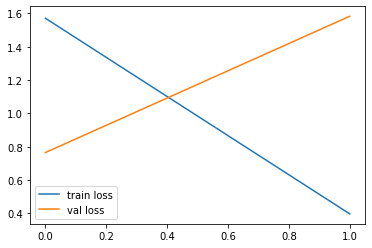

In [272]:
# Gráfico de loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

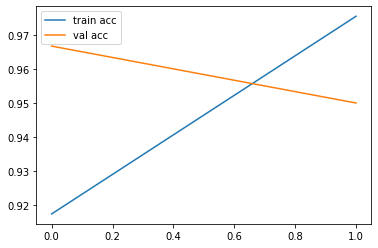

In [273]:
# Gráfico de accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

Percebe-se que mesmo com apenas 2 epochs o modelo foi capaz de se sair muito bem na classificação das imagens de teste.

In [274]:
# salvando os pesos do modelo.
model.save_weights('intel-classiffication.h5')

## Classificando uma única imagem.

In [275]:
import cv2

In [276]:
img = cv2.imread('predios.jfif')
res = cv2.resize(img, dsize=(224, 224))
res.resize(1, 224, 224, 3)

In [277]:
y_prob = model.predict(res)
y_classes = y_prob.argmax(axis=-1)
y_classes

array([0], dtype=int64)

In [278]:
train_datagen.class_indices

{'buildings': 0, 'forest': 1, 'mountain': 2}

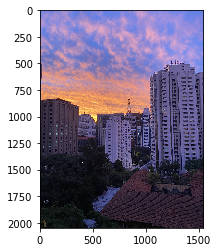

In [279]:
plt.imshow(image.load_img('predios.jfif'))

No fim o teste com uma única imagem, que não estava nem no módulo de testes nem no módulo de treino.
O modelo foi capaz de classificá-la corretamente.